# Flood Exposure Notebook

**Explore S2S Metadata and API**

This notebook walks through an example that explores the Space2Stats Metadata, and then uses the API to fetch flood data for various provinces within a country.

In [1]:
import pandas as pd
import geopandas as gpd
import requests
from shapely import from_geojson
from pystac import Catalog
from typing import Dict, Literal, List, Optional
import matplotlib.pyplot as plt # pip install matplotlib contextily
import contextily as ctx

In [2]:
BASE_URL = "https://space2stats.ds.io"
FIELDS_ENDPOINT = f"{BASE_URL}/fields"
SUMMARY_ENDPOINT = f"{BASE_URL}/summary"
AGGREGATION_ENDPOINT = f"{BASE_URL}/aggregate"
catalog = Catalog.from_file("https://raw.githubusercontent.com/worldbank/DECAT_Space2Stats/refs/heads/main/space2stats_api/src/space2stats_ingest/METADATA/stac/catalog.json")

## Helper Functions

The following python functions are wrappers to help interact with the API.

In [8]:
def get_topics(catalog: Catalog) -> pd.DataFrame:
    """Get a table of items (dataset themes/topics) from the STAC catalog."""
    items = catalog.get_all_items()
    items = list(items)
    topics = [{i.id: {k: v for k, v in i.properties.items() if k in ["name", "description", "source_data"]}} for i in items]
    topics = [pd.DataFrame(t) for t in topics]
    topics = pd.concat(topics, axis=1)
    topics.index.name = "Item ID"
    return topics.transpose()

def get_fields(item_id: str, catalog: Catalog) -> Dict:
    """Get a table with a description of variables for a given dataset (item)."""
    collection = next(catalog.get_collections())
    item = collection.get_item(item_id)
    fields = item.properties["table:columns"]
    return pd.DataFrame(fields)

def fetch_admin_boundaries(iso3: str, adm: str) -> gpd.GeoDataFrame:
    """Fetch administrative boundaries from GeoBoundaries API."""
    url = f"https://www.geoboundaries.org/api/current/gbOpen/{iso3}/{adm}/"
    res = requests.get(url, verify=False).json()
    return gpd.read_file(res["gjDownloadURL"])

def get_summary(
        gdf: gpd.GeoDataFrame, 
        spatial_join_method: Literal["touches", "centroid", "within"], 
        fields: List[str], 
        geometry: Optional[Literal["polygon", "point"]] = None
        ) -> pd.DataFrame:
    """Extract h3 level data from Space2Stats for a GeoDataFrame.

    Parameters
    ----------
    gdf : GeoDataFrame
        The Areas of Interest

    spatial_join_method : ["touches", "centroid", "within"]
        The method to use for performing the spatial join between the AOI and H3 cells
            - "touches": Includes H3 cells that touch the AOI
            - "centroid": Includes H3 cells where the centroid falls within the AOI
            - "within": Includes H3 cells entirely within the AOI

    fields : List[str]
        A list of field names to retrieve from the statistics table.

    geometry : Optional["polygon", "point"]
        Specifies if the H3 geometries should be included in the response. It can be either "polygon" or "point". If None, geometries are not included

    Returns
    -------
    DataFrame
        A DataFrame with the requested fields for each H3 cell that intersects with the AOIs.
    """
    res_all = {}
    for idx, row in gdf.iterrows():
        request_payload = {
            "aoi": {
                "type": "Feature",
                "geometry": row.geometry.__geo_interface__,
                "properties": {},
            },
            "spatial_join_method": spatial_join_method,
            "fields": fields,
            "geometry": geometry,
        }
        response = requests.post(SUMMARY_ENDPOINT, json=request_payload, verify=False)

        if response.status_code != 200:
            raise Exception(f"Failed to get summary: {response.text}")
        
        summary_data = response.json()
        if not summary_data:
            print(f"Failed to get summary for {idx}")
            summary_data = pd.DataFrame()  # Return an empty DataFrame if no data

        df = pd.DataFrame(summary_data)
        res_all[idx] = df
    
    res_all = pd.concat(res_all, names=["index_gdf", "index_h3"])
    res_all = res_all.reset_index()
    gdf_copy = gdf.copy()
    gdf_copy.drop(columns=["geometry"], inplace=True)
    res_all = gdf_copy.merge(res_all, left_index=True, right_on="index_gdf")
    return res_all

def get_aggregate(
        gdf: gpd.GeoDataFrame, 
        spatial_join_method: Literal["touches", "centroid", "within"],
        fields: list, 
        aggregation_type: Literal["sum", "avg", "count", "max", "min"]
    ) -> pd.DataFrame:
    """Extract summary statistic from underlying H3 Space2Stats data.

    Parameters
    ----------
    gdf : GeoDataFrame
        The Areas of Interest

    spatial_join_method : ["touches", "centroid", "within"]
        The method to use for performing the spatial join between the AOI and H3 cells
            - "touches": Includes H3 cells that touch the AOI
            - "centroid": Includes H3 cells where the centroid falls within the AOI
            - "within": Includes H3 cells entirely within the AOI

    fields : List[str]
        A list of field names to retrieve from the statistics table.

    aggregation_type : ["sum", "avg", "count", "max", "min"]
        Statistical function to apply to each field per AOI.

    Returns
    -------
    DataFrame
        A DataFrame with the requested fields for each H3 cell that intersects with the AOIs.
    
    """
    res_all = []
    for idx, row in gdf.iterrows():
        request_payload = {
            "aoi": {
                "type": "Feature",
                "geometry": row.geometry.__geo_interface__,
                "properties": {},
            },
            "spatial_join_method": spatial_join_method,
            "fields": fields,
            "aggregation_type": aggregation_type,
        }
        response = requests.post(AGGREGATION_ENDPOINT, json=request_payload, verify=False)

        if response.status_code != 200:
            raise Exception(f"Failed to get aggregate: {response.text}")
        
        aggregate_data = response.json()
        if not aggregate_data:
            print(f"Failed to get summary for {idx}")
            aggregate_data = pd.DataFrame()  # Return an empty DataFrame if no data

        df = pd.DataFrame(aggregate_data, index=[idx])
        res_all.append(df)
    
    res_all = pd.concat(res_all)
    gdf_copy = gdf.copy()
    res_all = gdf_copy.join(res_all)
    return res_all

## Query Metadata

Each dataset in Space2Stats is stored as a STAC item. Metadata for each item can be explored through the following [browser](https://radiantearth.github.io/stac-browser/#/external/raw.githubusercontent.com/worldbank/DECAT_Space2Stats/refs/heads/main/space2stats_api/src/space2stats_ingest/METADATA/stac/space2stats-collection/collection.json). 

The `get_topics` function retrieves a list of dictionaries with key details for each dataset. The keys in each dictionary are the item ids.

In [4]:
topics = get_topics(catalog)
pd.options.display.max_colwidth = None
topics

Item ID,name,description,source_data
space2stats_population_2020,Population,Gridded population disaggregated by gender.,"WorldPop gridded population, 2020, Unconstrained, UN-Adjusted, https://www.worldpop.org/methods/top_down_constrained_vs_unconstrained/"
flood_exposure_15cm_1in100,Population Exposed to Floods,"Population where flood depth is greater than 15 cm, 1-in-100 return period.","Fathom 3.0 High Resolution Global Flood Maps Including Climate Scenarios, https://datacatalog.worldbank.org/search/dataset/0065653/Fathom-3-0---High-Resolution-Global-Flood-Maps-Including-Climate-Scenarios"
urbanization_ghssmod,Urbanization by population and by area,"Urbanization is analyzed using the GHS-SMOD dataset, including comparisons with population",Global Human Settlement Layer (https://human-settlement.emergency.copernicus.eu/degurbaDefinitions.php)
nighttime_lights,Nighttime Lights,Sum of luminosity values measured by monthly composites from VIIRS satellite.,"World Bank - Light Every Night, https://registry.opendata.aws/wb-light-every-night/"


We can extract additional metadata like fields and descriptions using the item id.

In [5]:
fields = get_fields("flood_exposure_15cm_1in100", catalog)
fields

,name,description,type
0,hex_id,H3 unique identifier,object
1,pop,"Sum of Gridded Population, 2020",float32
2,pop_flood,"Sum of population exposed to floods greater than 15 cm, 1 in 100 return period",float64
3,pop_flood_pct,"Percent of population exposed to floods greater than 15 cm, 1 in 100 return period",float64


Alternatively, we can also explore the fields avaialble via the API fields endpoint:

In [10]:
response = requests.get(FIELDS_ENDPOINT, verify=False)
if response.status_code != 200:
    raise Exception(f"Failed to get fields: {response.text}")

available_fields = response.json()
print("Available Fields:", available_fields)

c:\wbg\Anaconda3\envs\s2s\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'space2stats.ds.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Available Fields: ['sum_viirs_ntl_2024', 'ogc_fid', 'sum_pop_f_0_2020', 'sum_pop_f_10_2020', 'sum_pop_f_15_2020', 'sum_pop_f_1_2020', 'sum_pop_f_20_2020', 'sum_pop_f_25_2020', 'sum_pop_f_30_2020', 'sum_pop_f_35_2020', 'sum_pop_f_40_2020', 'sum_pop_f_45_2020', 'sum_pop_f_50_2020', 'sum_pop_f_55_2020', 'sum_pop_f_5_2020', 'sum_pop_f_60_2020', 'sum_pop_f_65_2020', 'sum_pop_f_70_2020', 'sum_pop_f_75_2020', 'sum_pop_f_80_2020', 'sum_pop_m_0_2020', 'sum_pop_m_10_2020', 'sum_pop_m_15_2020', 'sum_pop_m_1_2020', 'sum_pop_m_20_2020', 'sum_pop_m_25_2020', 'sum_pop_m_30_2020', 'sum_pop_m_35_2020', 'sum_pop_m_40_2020', 'sum_pop_m_45_2020', 'sum_pop_m_50_2020', 'sum_pop_m_55_2020', 'sum_pop_m_5_2020', 'sum_pop_m_60_2020', 'sum_pop_m_65_2020', 'sum_pop_m_70_2020', 'sum_pop_m_75_2020', 'sum_pop_m_80_2020', 'sum_pop_m_2020', 'sum_pop_f_2020', 'sum_pop_2020', 'pop', 'pop_flood', 'pop_flood_pct', 'ghs_11_count', 'ghs_12_count', 'ghs_13_count', 'ghs_21_count', 'ghs_22_count', 'ghs_23_count', 'ghs_30_count

## Extract H3 Data

Let's work with the subset of fields from the flood exposure item: `['pop', 'pop_flood', 'pop_flood_pct']`

In [11]:
flood_vars = ['pop', 'pop_flood', 'pop_flood_pct']

We will define our AOIs by fetching admin boundaries from the GeoBoundaries project.

c:\wbg\Anaconda3\envs\s2s\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.geoboundaries.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Axes: >

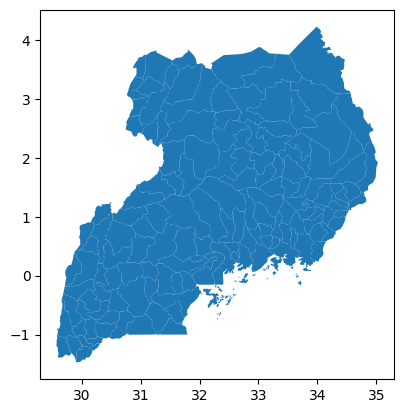

In [12]:
ISO3 = "UGA" # South Sudan
ADM = "ADM2" # Level 2 administrative boundaries
adm_boundaries = fetch_admin_boundaries(ISO3, ADM)
adm_boundaries.plot()

In [13]:
get_summary?


Signature:
get_summary(
    gdf: geopandas.geodataframe.GeoDataFrame,
    spatial_join_method: Literal['touches', 'centroid', 'within'],
    fields: List[str],
    geometry: Optional[Literal['polygon', 'point']] = None,
) -> pandas.core.frame.DataFrame
Docstring:
Extract h3 level data from Space2Stats for a GeoDataFrame.

Parameters
----------
gdf : GeoDataFrame
    The Areas of Interest

spatial_join_method : ["touches", "centroid", "within"]
    The method to use for performing the spatial join between the AOI and H3 cells
        - "touches": Includes H3 cells that touch the AOI
        - "centroid": Includes H3 cells where the centroid falls within the AOI
        - "within": Includes H3 cells entirely within the AOI

fields : List[str]
    A list of field names to retrieve from the statistics table.

geometry : Optional["polygon", "point"]
    Specifies if the H3 geometries should be included in the response. It can be either "polygon" or "point". If None, geometries are not inclu

Run API Calls

In [14]:
df = get_summary(
    gdf=adm_boundaries, 
    spatial_join_method="centroid", 
    fields=flood_vars,
    geometry="polygon"
)

c:\wbg\Anaconda3\envs\s2s\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'space2stats.ds.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\wbg\Anaconda3\envs\s2s\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'space2stats.ds.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\wbg\Anaconda3\envs\s2s\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'space2stats.ds.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\wbg\Anaconda3\envs\s2s\Lib\site-packages\urlli

In [15]:
pd.reset_option('display.max_colwidth')
df.head()

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,index_gdf,index_h3,hex_id,geometry,pop,pop_flood,pop_flood_pct
0,Dodoth,,47994165B4837390146164,UGA,ADM2,0,0,866a58417ffffff,"{""type"":""Polygon"",""coordinates"":[[[34.07412941...",282.164980,20.147796,0.071404
1,Dodoth,,47994165B4837390146164,UGA,ADM2,0,1,866a58437ffffff,"{""type"":""Polygon"",""coordinates"":[[[34.06455640...",485.713100,79.029955,0.162709
2,Dodoth,,47994165B4837390146164,UGA,ADM2,0,2,866a58487ffffff,"{""type"":""Polygon"",""coordinates"":[[[34.03663669...",76.748710,6.447369,0.084006
3,Dodoth,,47994165B4837390146164,UGA,ADM2,0,3,866a5848fffffff,"{""type"":""Polygon"",""coordinates"":[[[34.09328847...",54.135690,3.051911,0.056375
4,Dodoth,,47994165B4837390146164,UGA,ADM2,0,4,866a58497ffffff,"{""type"":""Polygon"",""coordinates"":[[[33.98954570...",82.921684,12.219088,0.147357


Check that there are no duplicate hexagon ids

In [16]:
df['hex_id'].duplicated().sum()

0

Convert geometry column from geojson into shapely polygons

In [17]:
df["geometry"] = df["geometry"].apply(lambda geom: from_geojson(geom))
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
gdf.head()

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,index_gdf,index_h3,hex_id,geometry,pop,pop_flood,pop_flood_pct
0,Dodoth,,47994165B4837390146164,UGA,ADM2,0,0,866a58417ffffff,"POLYGON ((34.07413 4.01749, 34.08662 4.04842, ...",282.164980,20.147796,0.071404
1,Dodoth,,47994165B4837390146164,UGA,ADM2,0,1,866a58437ffffff,"POLYGON ((34.06456 4.07494, 34.07705 4.10585, ...",485.713100,79.029955,0.162709
2,Dodoth,,47994165B4837390146164,UGA,ADM2,0,2,866a58487ffffff,"POLYGON ((34.03664 3.92464, 34.04914 3.9556, 3...",76.748710,6.447369,0.084006
3,Dodoth,,47994165B4837390146164,UGA,ADM2,0,3,866a5848fffffff,"POLYGON ((34.09329 3.9025, 34.10578 3.93346, 3...",54.135690,3.051911,0.056375
4,Dodoth,,47994165B4837390146164,UGA,ADM2,0,4,866a58497ffffff,"POLYGON ((33.98955 3.88925, 34.00206 3.92023, ...",82.921684,12.219088,0.147357


Map hexagon data

SSLError: HTTPSConnectionPool(host='server.arcgisonline.com', port=443): Max retries exceeded with url: /ArcGIS/rest/services/World_Physical_Map/MapServer/tile/7/62/74 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1006)')))

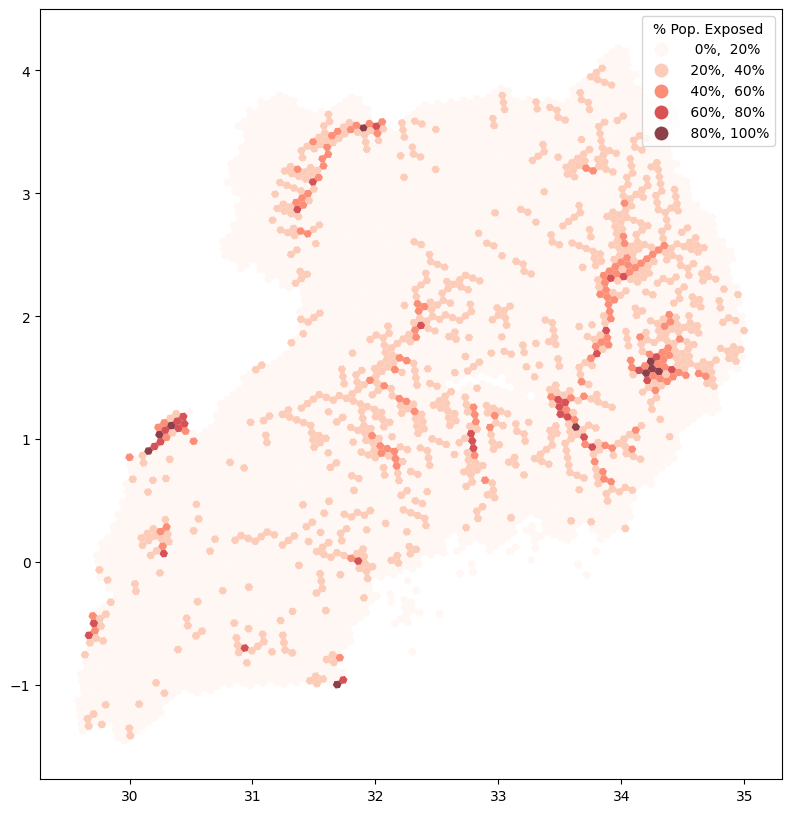

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(ax=ax, column="pop_flood_pct", 
         legend=True, cmap="Reds", alpha=0.75, 
         scheme="equal_interval", k=5, 
         legend_kwds=dict(title='% Pop. Exposed', fmt="{:.0%}"),
         linewidth=0)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldPhysical, crs='EPSG:4326')
plt.axis("off")
plt.show()

## Extract Admin Summaries

In [ ]:
adm_boundaries_zs = get_aggregate(
    gdf=adm_boundaries, 
    spatial_join_method="centroid", 
    fields=['pop', 'pop_flood'], 
    aggregation_type="sum"
)

In [ ]:
adm_boundaries_zs.head()

Recalculate share of population exposed with aggregate data

In [ ]:
adm_boundaries_zs.loc[:, "pop_flood_pct"] = adm_boundaries_zs["pop_flood"] / adm_boundaries_zs["pop"]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
adm_boundaries_zs.plot(
    ax=ax, column="pop_flood_pct", legend=True, 
    cmap="Reds", scheme="natural_breaks", 
    k=5, legend_kwds=dict(title='% Pop. Exposed', fmt="{:.0%}"),
    linewidth=0.2, edgecolor='black')
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldPhysical, crs='EPSG:4326')
plt.axis("off")
plt.show()

List top 20 provinces by population exposed

In [ ]:
table = adm_boundaries_zs.sort_values('pop_flood_pct', ascending=False).head(20)[['shapeName', 'pop_flood', 'pop_flood_pct']].rename(
    columns={
        'shapeName': 'Province'
        })
table.loc[:, "Population Exposed"] = table.loc[:, "pop_flood"].apply(lambda x: f"{x:,.0f}")
table.loc[:, "Population Exposed (%)"] = table.loc[:, "pop_flood_pct"].apply(lambda x: f"{x:.2%}")
table.reset_index(drop=True, inplace=True)
display(table[['Province', 'Population Exposed', 'Population Exposed (%)']])